In [1]:
from lib.all import all_in_one
from lib.prepare_data import make_cut, to_categorical
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings


from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "./training/pred_tremi.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "./training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('float'),
        'heating_production': F.col('heating_production').cast('int'),
        'heating_emission': F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [5]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop(
    'heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop(
    'heating_emission', 'heating_production')

training_prod = training_tremi.filter(
    F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(
    F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(
    F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(
    F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
{training_em.count() =}
{predicting_em.count() =}
""")


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370

training_em.count() =12558
predicting_em.count() =26940



# ML

In [6]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# linear
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# HistGboost
from sklearn.ensemble import HistGradientBoostingClassifier

#hyperparams
from scipy.stats import uniform, randint

In [7]:
# make the best split
best_cut=(70,45,1)
cuts = make_cut(*best_cut)
training_surf, coef = to_categorical(training_surf, 'surface', cuts)

## surface

0.6085648148148148 {'C': 59.08361216819946, 'class_weight': 'balanced', 'max_iter': 1000}
0.6347993827160493 {'learning_rate': 0.2868972875634277, 'max_depth': 1, 'n_estimators': 123}
0.6317901234567902 {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 122}
0.6320987654320988 {'l2_regularization': 0.5426960831582485, 'learning_rate': 0.0722772674924288, 'max_iter': 114}
not handled for this type of algorithm


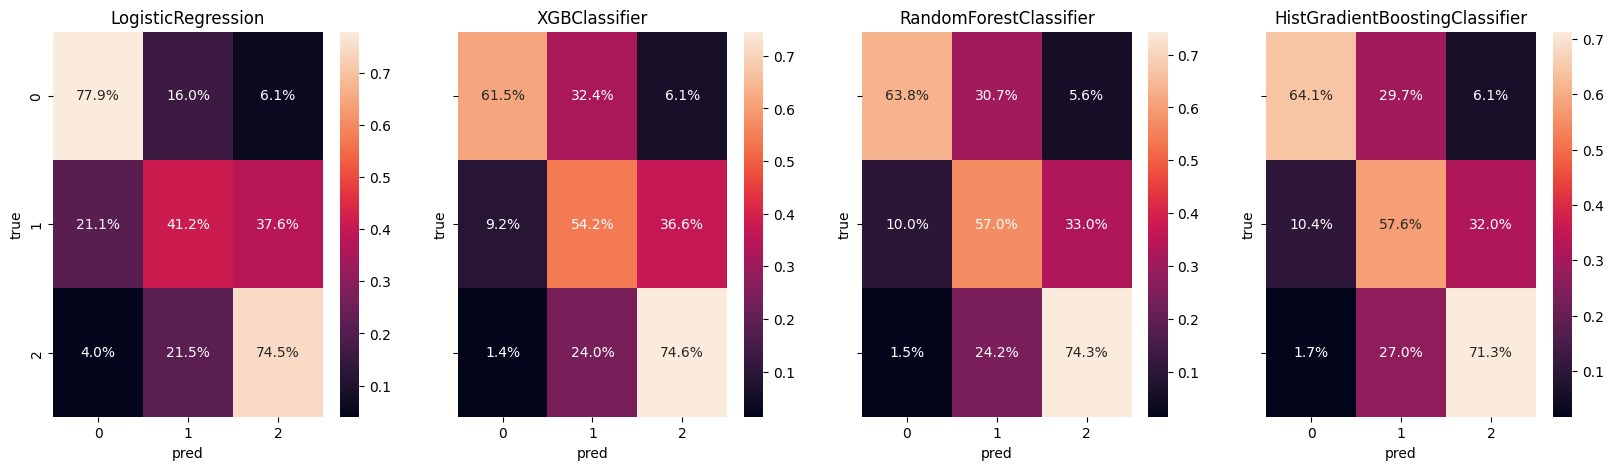

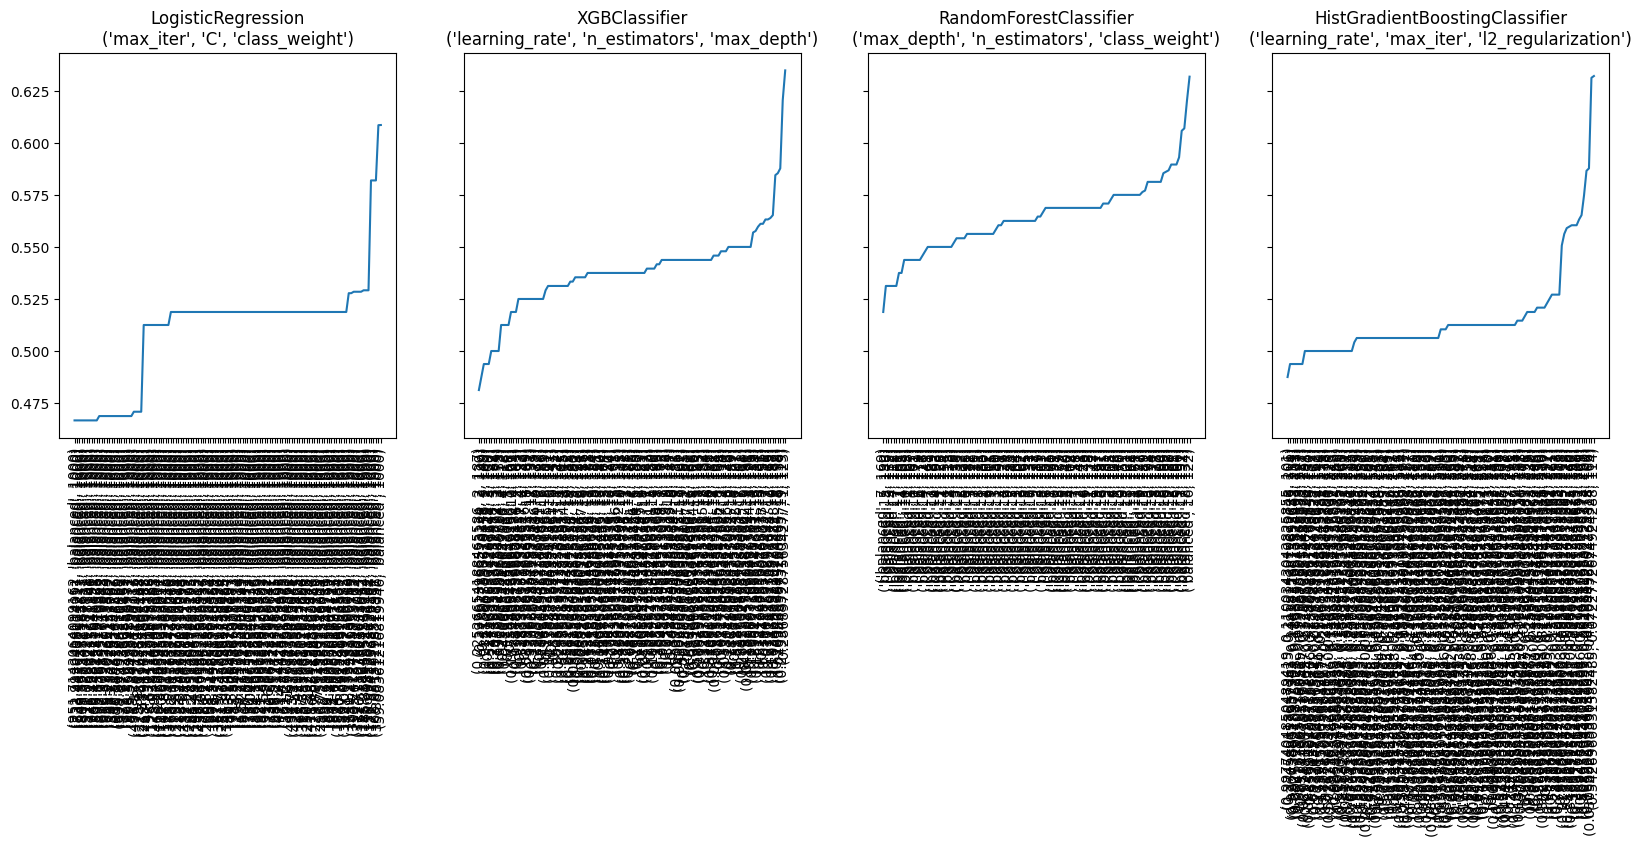

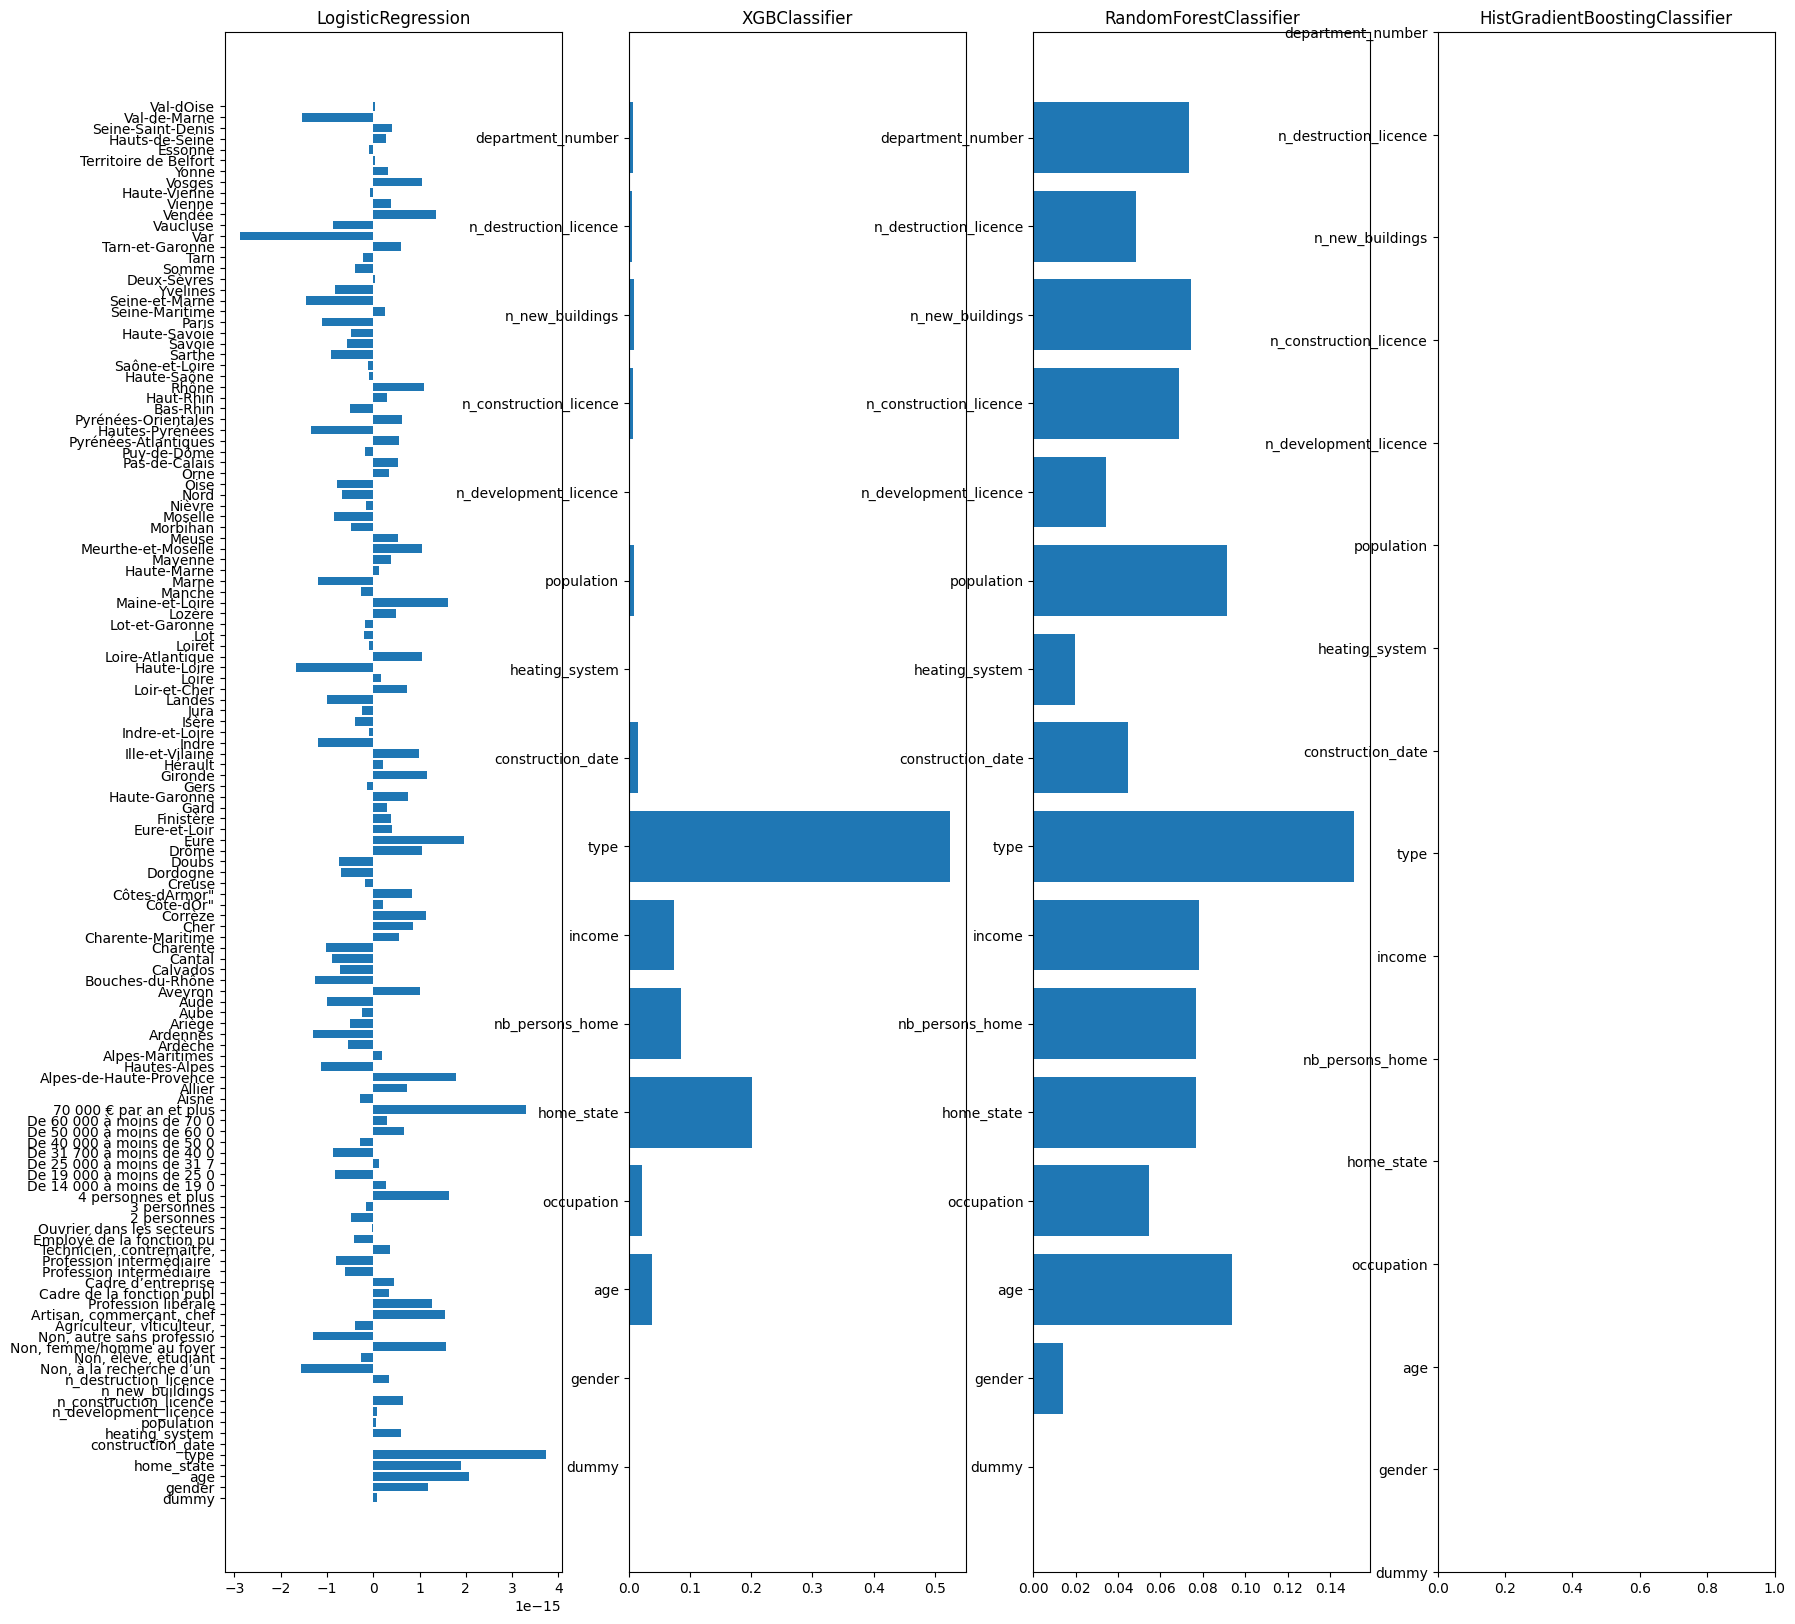

In [9]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], [], []]
col_y = ['surface']
col_X_not_hot = [[col[0] for col in training_surf.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

categorical_features = [i for i in range(9)] + [14]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': uniform(1,1000),
        'class_weight': ['balanced'],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'max_iter' : randint(100,300),
        'l2_regularization' : uniform(0,1),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'XGBClassifier': XGBClassifier,
    'RandomForestClassifier' : RandomForestClassifier,
    'HistGradientBoostingClassifier' : HistGradientBoostingClassifier,
}
best_models_surf = all_in_one(training_surf, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)

## heating_production 

In [10]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], [], []]
col_y = ['heating_production']
col_X_not_hot = [[col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]
print(col_X_not_hot)

categorical_features = [i for i in range(9)] + [14]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': uniform(1,1000),
        'class_weight': ['balanced'],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(5,20),
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(5,20),
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'max_iter' : randint(100,300),
        'l2_regularization' : uniform(0,1),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'XGBClassifier': XGBClassifier,
    'RandomForestClassifier' : RandomForestClassifier,
    'HistGradientBoostingClassifier' : HistGradientBoostingClassifier,
}
best_models_prod = all_in_one(training_prod, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4)

[['gender', 'age', 'home_state', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence'], ['gender', 'age', 'occupation', 'home_state', 'nb_persons_home', 'income', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'department_number'], ['gender', 'age', 'occupation', 'home_state', 'nb_persons_home', 'income', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'department_number'], ['gender', 'age', 'occupation', 'home_state', 'nb_persons_home', 'income', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'department_number']]
0.2996913580246914 {'C': 6.522117123602399, 'class_

## heating_emission

[['gender', 'age', 'home_state', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence'], ['gender', 'age', 'occupation', 'home_state', 'nb_persons_home', 'income', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'department_number'], ['gender', 'age', 'occupation', 'home_state', 'nb_persons_home', 'income', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'department_number'], ['gender', 'age', 'occupation', 'home_state', 'nb_persons_home', 'income', 'type', 'construction_date', 'heating_system', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'department_number']]


KeyboardInterrupt: 

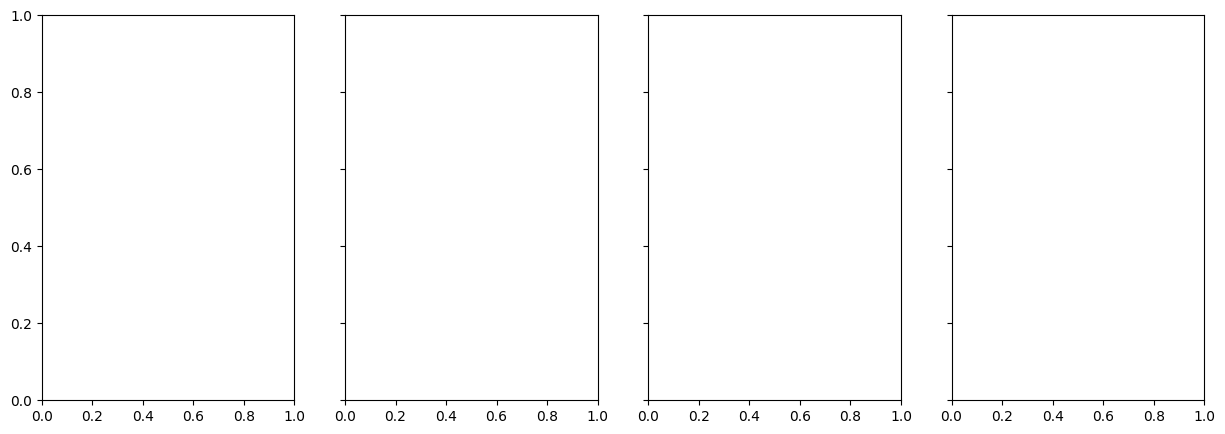

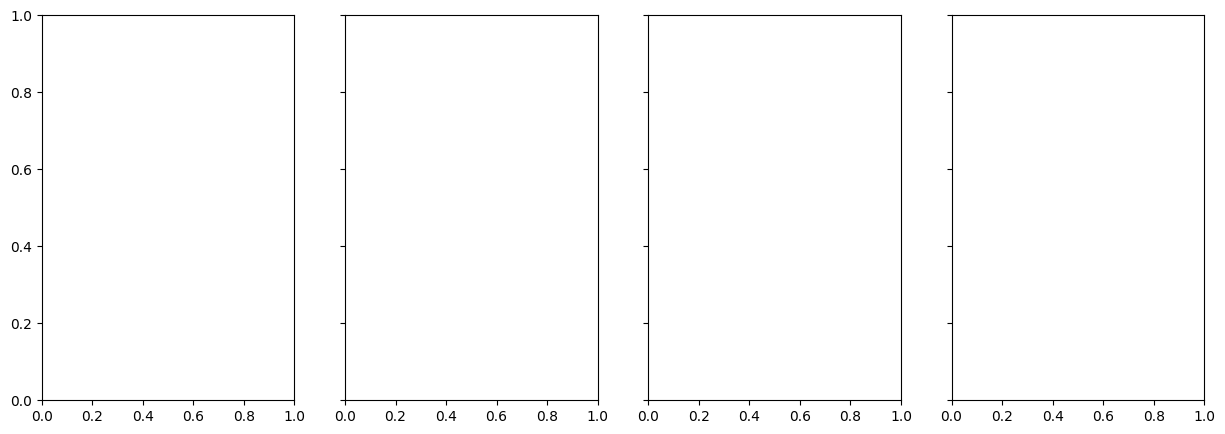

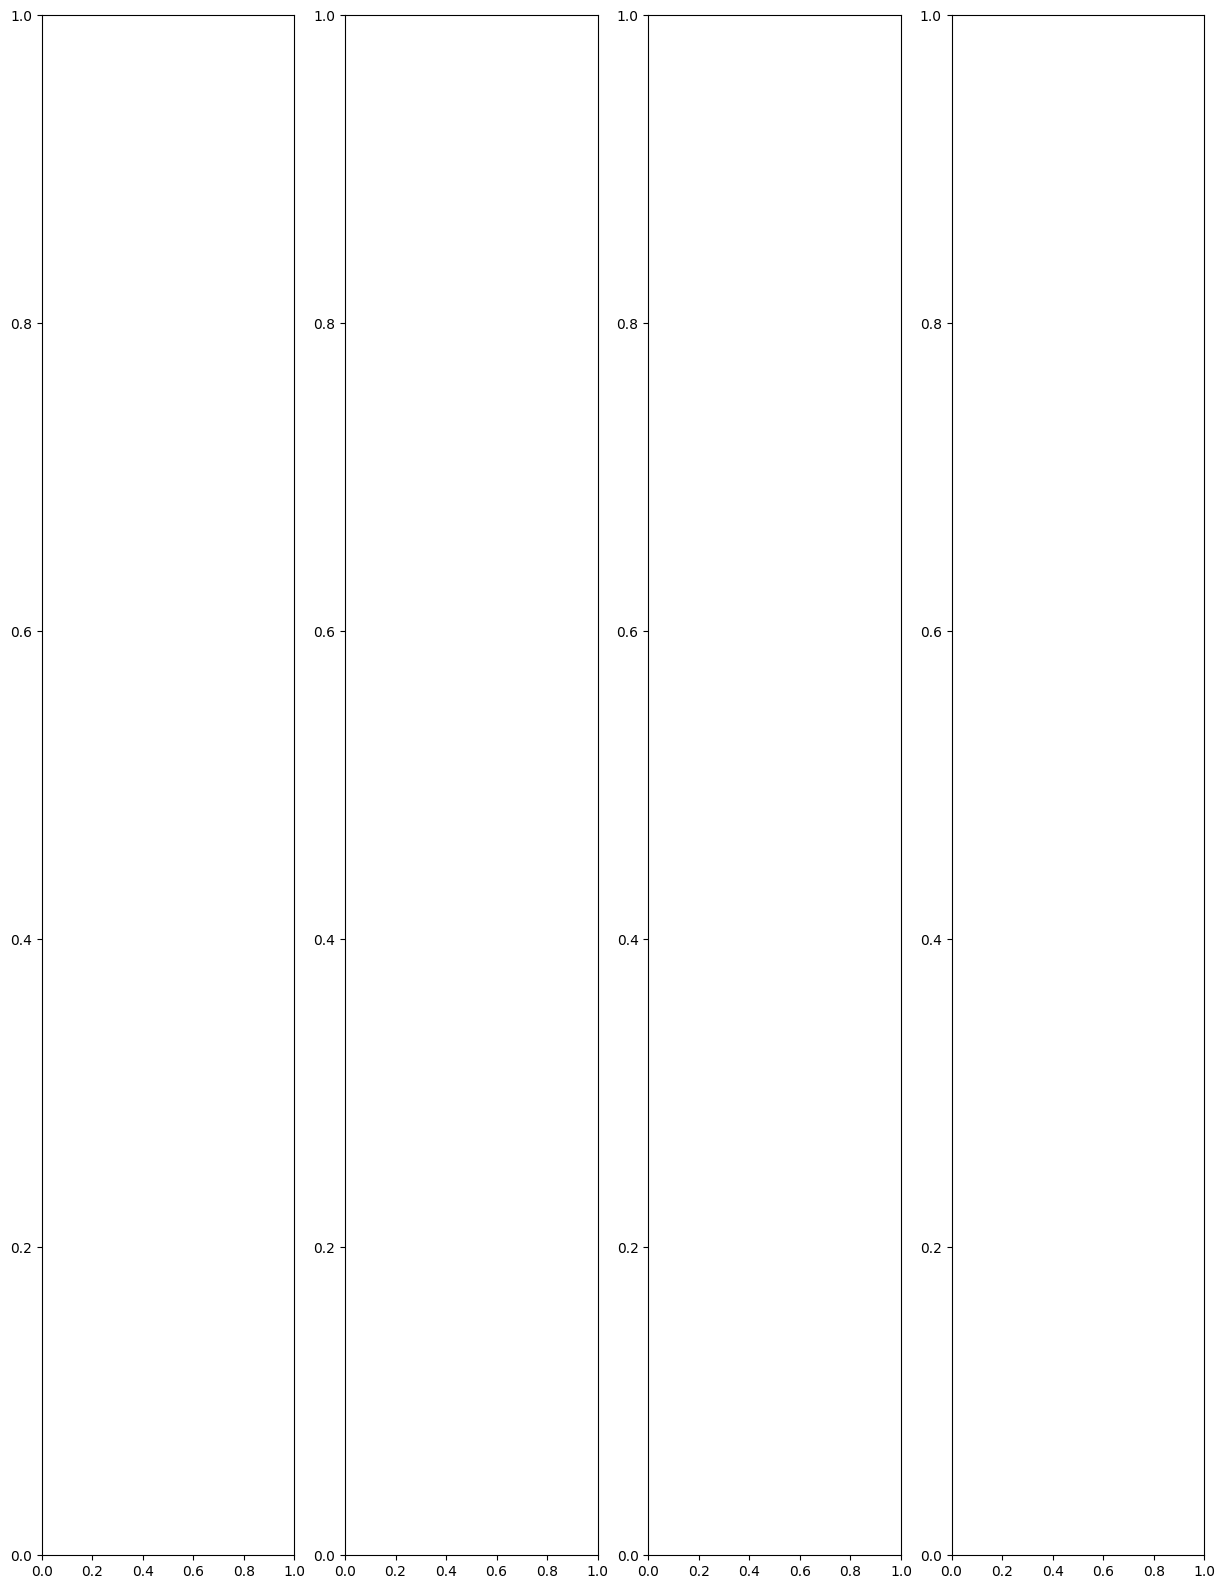

In [ ]:
col_X_hot = [['occupation', 'nb_persons_home',
              'income', 'department_number'], [], [], []]
col_y = ['heating_emission']
col_X_not_hot = [[col[0] for col in training_em.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]
print(col_X_not_hot)

categorical_features = [i for i in range(9)] + [14]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': uniform(1,1000),
        'class_weight': ['balanced'],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'max_iter' : (100,300),
        'l2_regularization' : uniform(0,1),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'XGBClassifier': XGBClassifier,
    'RandomForestClassifier' : RandomForestClassifier,
    'HistGradientBoostingClassifier' : HistGradientBoostingClassifier,
}
best_models_em = all_in_one(training_em, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.2)